# 1. 손글씨 도형


In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [58]:
%cd /content/drive/MyDrive/AI활용 소프트웨어 개발/10. 파이썬 웹 서비스/12.딥러닝/data
# 경로 이동

/content/drive/MyDrive/AI활용 소프트웨어 개발/10. 파이썬 웹 서비스/12.딥러닝/data


In [59]:
!unzip -qq "shape.zip" # 압축 풀기

replace shape/test/cir/drawing(10).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [60]:
train_path = '/content/drive/MyDrive/AI활용 소프트웨어 개발/10. 파이썬 웹 서비스/12.딥러닝/data/shape/train'
test_path = '/content/drive/MyDrive/AI활용 소프트웨어 개발/10. 파이썬 웹 서비스/12.딥러닝/data/shape/test'

In [61]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(1), # 이미지를 그레이스케일로 변환. 1 : 채널수
    transforms.ToTensor(),
    transforms.RandomInvert(1), # 색 반전 (검정<->흰색). 확률 :1 이면 무조건 반전시켜라
    # CNN은 손글씨, 글자를 이해하기 위해서는 검은바탕에 흰글씨를 훨씬 더 잘 찾아냄.
    transforms.Normalize((0.5), (0.5)) # 평균, 표준편차를 0.5로 맞춰라. (-1 ~ 1 로 스케일 조정)
])

In [62]:
trainset = torchvision.datasets.ImageFolder(root= train_path, transform=transform)
testset = torchvision.datasets.ImageFolder(root= test_path, transform=transform)

len(trainset), len(testset)

(240, 60)

In [63]:
# 데이터셋이기 때문에 아래의 기능도 할 수 있다.
print(trainset.__getitem__(10))

(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -

In [64]:
print(trainset.classes, testset.classes)

['cir', 'tri', 'x'] ['cir', 'tri', 'x']


In [65]:
# 클래스별로 묶어주기
class_map = {
    0: 'cir',
    1: 'tri',
    2: 'x'
}

In [66]:
loader = DataLoader(
    dataset=trainset,
    batch_size=64,
    shuffle=True,
)

imgs, labels = next(iter(loader))
print(imgs.shape, labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


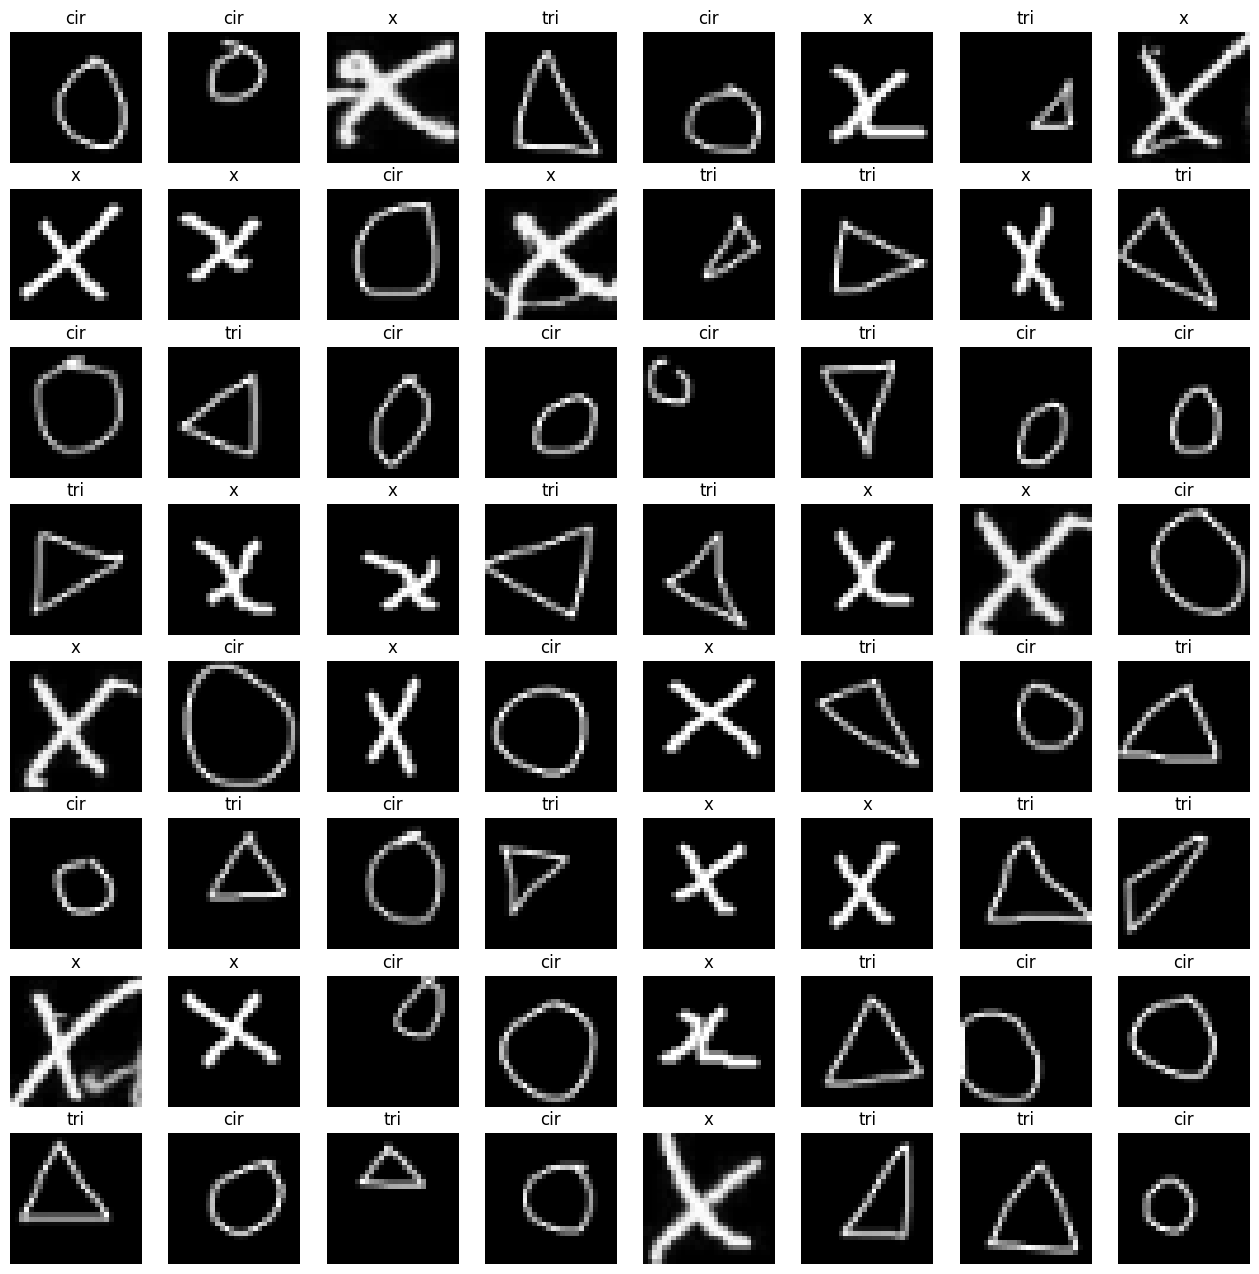

In [67]:
fig, axes = plt.subplots(8, 8, figsize=(16, 16))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.reshape(28, 28), cmap='gray')
    ax.set_title(class_map[label.item()])
    ax.axis('off')

In [68]:
# 장치 확인
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


# 2. CNN 모델 만들기

In [69]:
class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Conv2d(1, 28, kernel_size=3, padding='same'),
            nn.ReLU(),

            nn.Conv2d(28, 28, kernel_size=3, padding='same'),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),

            nn.Conv2d(28, 56, kernel_size=3, padding='same'),
            nn.ReLU(),

            nn.Conv2d(56, 56, kernel_size=3, padding='same'),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25)
        )
        self.Linear = nn.Linear(56 * 7 * 7, 3)

    def forward(self, x):
        x = self.classifier(x)
        x = self.flatten(x)
        output = self.Linear(x)
        return output

In [70]:
model = ConvNeuralNetwork().to(device)
print(model)

ConvNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(28, 56, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
  )
  (Linear): Linear(in_features=2744, out_features=3, bias=True)
)


In [71]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [72]:
def train_loop(train_loader, model, loss_fn, optimizer):
    sum_losses = 0
    sum_accs = 0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 매 배치마다 loss = loss_fn(y_pred, y_batch)로 구한 배치 손실(batch loss) 들을 모두 더한 값이 쌓임
        sum_losses = sum_losses + loss

        y_prob = nn.Softmax(1)(y_pred)
        y_pred_index = torch.argmax(y_prob, axis=1)
        acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
        # 매 배치마다 구한 배치 정확도(batch accuracy) 들이 퍼센트(%) 단위로 더해짐
        sum_accs = sum_accs + acc
    # 한 에폭동안 배치 단위로 계산된 손실과 정확도의 평균값
    avg_loss = sum_losses / len(train_loader) # 평균 loss
    avg_acc = sum_accs / len(train_loader) # 평균 acc
    return avg_loss, avg_acc

In [73]:
epochs = 50

for epoch in range(1,epochs +1):

    avg_loss, avg_acc = train_loop(loader, model, loss, optimizer)
    if epoch % 10 == 0:
        print(f"------------------------------------------------")
        print(f'Epoch {epoch:4d}/{epochs} Loss: {avg_loss:.6f} Accuracy: {avg_acc:.2f}%')
print("Done!")

------------------------------------------------
Epoch   10/50 Loss: 0.292710 Accuracy: 88.41%
------------------------------------------------
Epoch   20/50 Loss: 0.148685 Accuracy: 95.31%
------------------------------------------------
Epoch   30/50 Loss: 0.043866 Accuracy: 98.44%
------------------------------------------------
Epoch   40/50 Loss: 0.012906 Accuracy: 100.00%
------------------------------------------------
Epoch   50/50 Loss: 0.002470 Accuracy: 100.00%
Done!


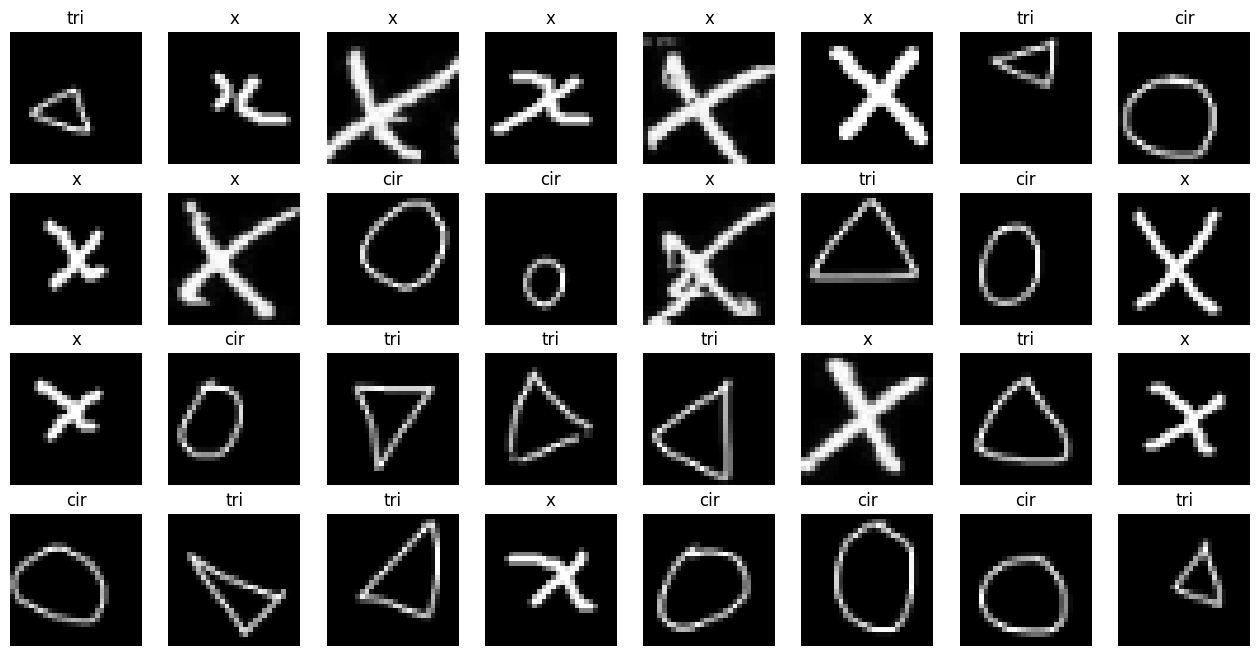

In [74]:
# 테스트 데이터 로드
test_loader = DataLoader(
    dataset=testset,
    batch_size=32,
    shuffle=True
)

imgs, labels = next(iter(test_loader))
fig, axes = plt.subplots(4, 8, figsize=(16, 8))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.reshape(28, 28), cmap='gray')
    ax.set_title(class_map[label.item()])
    ax.axis('off')

In [75]:
def test(model, loader):
    model.eval() # 테스트 모드로 동작한다는 뜻. 그래디언트 동작을 막아주고 메모리 아끼게 됨

    sum_accs = 0

    # 같은 디바이스로 다 옮겨줌
    img_list = torch.Tensor().to(device)
    y_pred_list = torch.Tensor().to(device)
    y_true_list = torch.Tensor().to(device)

    for x_batch, y_batch in loader:
        x_batch = x_batch.to(device)  # 같은 디바이스로 다 옮겨줌
        y_batch = y_batch.to(device)  # 같은 디바이스로 다 옮겨줌
        y_pred = model(x_batch) # 예측하기
        y_prob = nn.Softmax(1)(y_pred) # 확률 구하기
        y_pred_index = torch.argmax(y_prob, axis=1) # 확률이 가장 높은 데이터의 인덱스 구하기
        y_pred_list = torch.cat((y_pred_list, y_pred_index), dim=0) # 예측값을 행으로 계속 붙여줌
        y_true_list = torch.cat((y_true_list, y_batch), dim=0) # 정답값을 행으로 계속 붙여줌
        img_list = torch.cat((img_list, x_batch), dim=0) # 이미지 리스트를 행으로 계속 붙여줌
        acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100 # 맞으면 1 아니면 0
        sum_accs += acc # 그리고 계속 더함. (정확도 구하기 위해서)

    avg_acc = sum_accs / len(loader)
    return y_pred_list, y_true_list, img_list, avg_acc

In [76]:
y_pred_list, y_true_list, img_list, avg_acc = test(model, test_loader)
print(f'테스트 정확도는 {avg_acc:.2f}% 입니다.')

테스트 정확도는 89.96% 입니다.


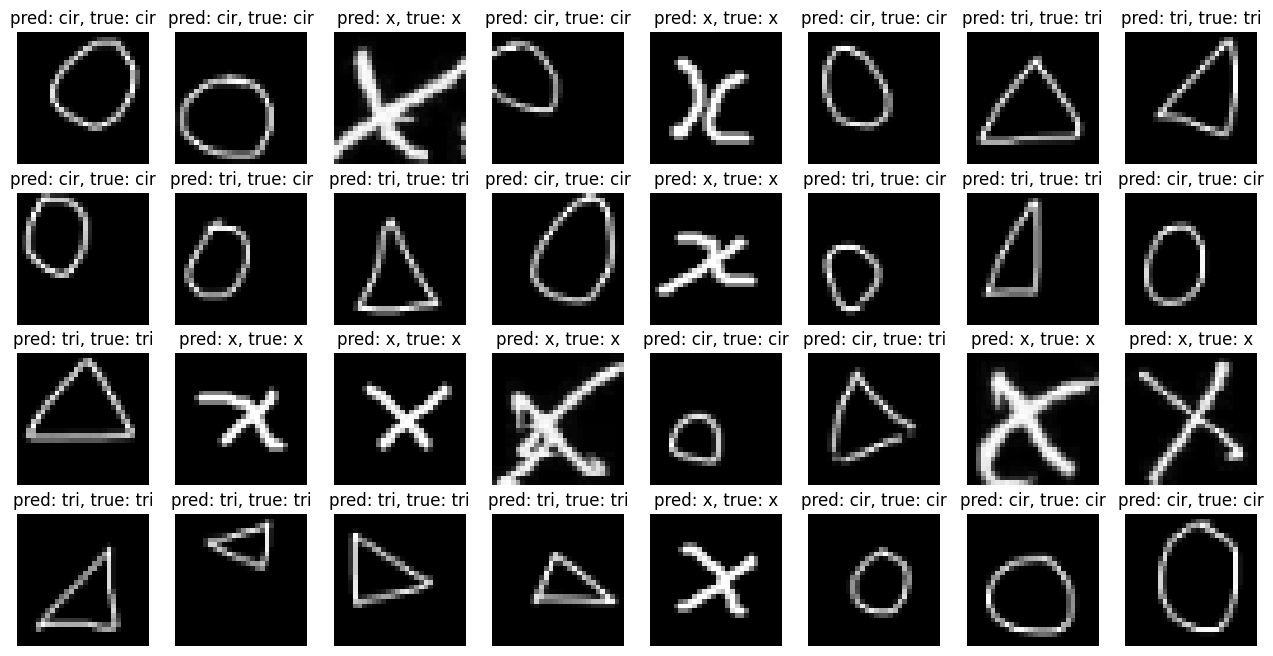

In [77]:
fig, axes = plt.subplots(4, 8, figsize=(16, 8))

img_list_cpu = img_list.cpu()
y_pred_list_cpu = y_pred_list.cpu()
y_true_list_cpu = y_true_list.cpu()

for ax, img, y_pred, y_true in zip(axes.flatten(), img_list_cpu, y_pred_list_cpu, y_true_list_cpu):
  ax.imshow(img.reshape(28, 28), cmap='gray')
  ax.set_title(f'pred: {class_map[y_pred.item()]}, true: {class_map[y_true.item()]}')
  ax.axis('off')

plt.show()

# 3. 모델 저장하고 불러오기

### 1. 모델의 가중치와 매개변수만 저장
모델의 구조가 저장되지 않으므로 모델 클래스 정의가 없으면 복원할 수 없음

In [98]:
torch.save(model.state_dict(), 'model_weights.pth') # 가중치만 저장함

In [99]:
model2 = ConvNeuralNetwork().to(device)
print(model2) #학습된 게 아님

ConvNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(28, 56, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
  )
  (Linear): Linear(in_features=2744, out_features=3, bias=True)
)


In [100]:
y_pred_list, y_true_list, img_list, avg_acc = test(model2, test_loader)
print(f'테스트 정확도는 {avg_acc:.2f}% 입니다.')

테스트 정확도는 33.48% 입니다.


In [101]:
model2.load_state_dict(torch.load('model_weights.pth'))

<All keys matched successfully>

In [102]:
y_pred_list, y_true_list, img_list, avg_acc = test(model2, test_loader)
print(f'테스트 정확도는 {avg_acc:.2f}% 입니다.')

테스트 정확도는 90.18% 입니다.


In [103]:
# 모델 전체를 저장
# 모델 클래스와 가중치가 함께 저장되므로, 복원 시 모델 구조를 별도로 정의할 필요 없음
torch.save(model, 'model.pth')

### 2. 모델 전체를 저장
모델 클래스와 가중치가 함께 저장되므로 복원 시 모델 구조를 별도로 정의할 필요 없음

In [105]:
torch.save(model, 'model.pth')

In [107]:
model3 = torch.load('model.pth', weights_only=False)

In [109]:
y_pred_list, y_true_list, img_list, avg_acc = test(model3, test_loader)
print(f'테스트 정확도는 {avg_acc:.2f}% 입니다.')

테스트 정확도는 89.96% 입니다.
